# Final Tutorial: CVE Vulnerability Analysis
### Sushant Tamrakar
### Eric Reasoner

## Introduction
The motivation for this project came from my reading of the article by Motherboard, titled [The Internet Has A Huge C/C++ Problem and Developers Don't Want to Deal With It](https://motherboard.vice.com/en_us/article/a3mgxb/the-internet-has-a-huge-cc-problem-and-developers-dont-want-to-deal-with-it). In this article, the Rust developer Alex Gaynor, argues that bugs like Heartbleed and WannaCry are due to memory unsafety in the language itself. He promotes Rust as a viable memory safe language to possibly replace programs written in C/C++. He reasons why memory unsafety is still prevalent when we have language like Swift and Rust. He mentions the cost of change and the plethora of already written libraries that are faced with transition cost. However, he notes that developers ignore the problem of safety largely, arguing that people should just code better. In this project, I would like to look more into Alex's claims of Memory Unsafety error, largely Buffer Overflow, which seems to be a large case of vulnerabilites according to him. Furthermore, we would also like to see what other vulnerabilites are more common in C/C++

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Lets's gather the data from the csv. The cve_data.csv contains all the vulnerabilities from NVD's data feeds. It consists the vulnerabilties from year early 1990s to December 2018. The cwelist.csv is the list of CWE categories with their description name. We need this table as the cve_data.csv scraped from NVD's data feeds only lists CWE-IDs and not the actual description of them. Thus we are joining the table to make a understandable final table

In [2]:
cve_data = pd.DataFrame.from_csv('cve_data.csv')
cwe_list = pd.DataFrame.from_csv('cwelist.csv')
cwe_list = cwe_list.rename(columns={'CWE':'Name','CWE-ID':'CWE_Description'})
cwe_list = cwe_list.drop('Description',axis=1)
cve_data = cve_data.join(cwe_list,on='CWE')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


### Full Discretion: I initially wrote the scrape_data.py script in here in jupyter. However, it refused to work for more than 3 or 4 files in the loop. I think this is possibly due to some open file limit on jupyter running on docker. Therefore, I wrote the script separately and ran it to produce the corresponding csv that I have used here. Please look at the scrape_data.py for how data scraping was done from the NIST website as well as CWE data

In [3]:
cve_data.head()

,CVE_ID,CWE,accessVector,accessComplexity,authentication,confidentialityImpact,integrityImpact,availabilityImpact,baseScore,severity,exploitabilityScore,impactScore,publishedDate,lastModifiedDate,CWE_Description
0,CVE-1999-0001,CWE-20,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,1999-12-30T05:00Z,2010-12-16T05:00Z,Input Validation
1,CVE-1999-0002,CWE-119,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-10-12T04:00Z,2009-01-26T05:00Z,Buffer Errors
2,CVE-1999-0003,NVD-CWE-Other,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-04-01T05:00Z,2018-10-30T16:26Z,Other
3,CVE-1999-0004,NVD-CWE-Other,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,1997-12-16T05:00Z,2018-10-12T21:29Z,Other
4,CVE-1999-0005,NVD-CWE-Other,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,1998-07-20T04:00Z,2008-09-09T12:33Z,Other


## Exploratory Data Analysis

Before we go to look at Memory related vulnerabilities, lets look at the frequency of vulnerabilities over the years. For this we will be using Seaborn's counplot function and plotting that horizontally.

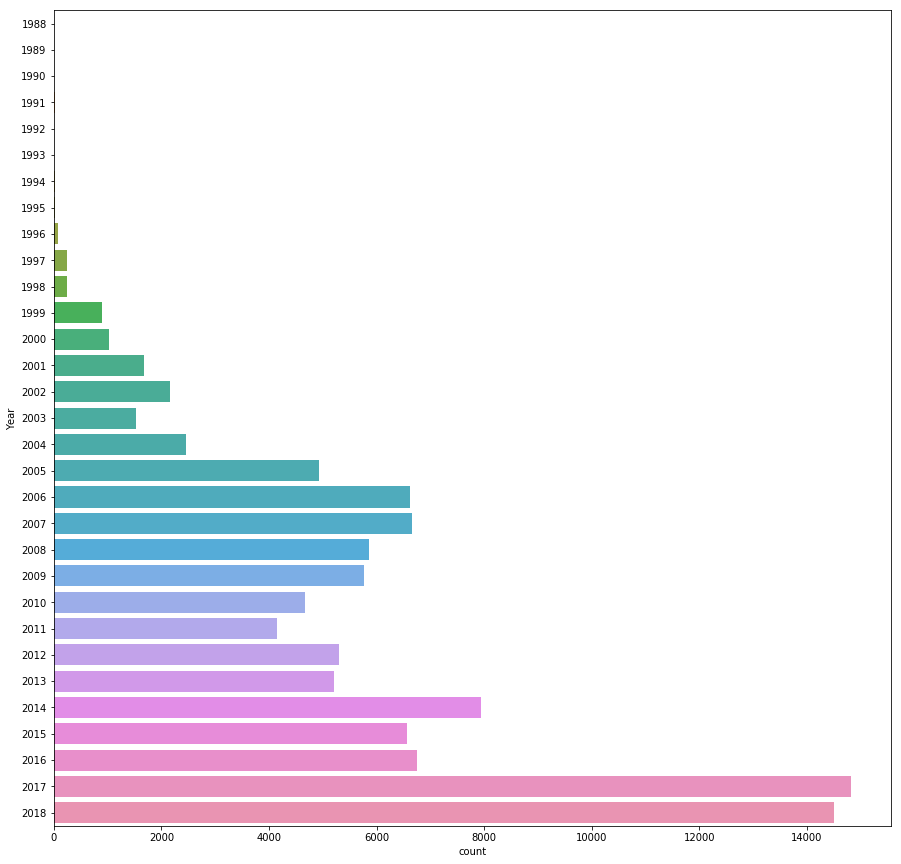

In [12]:
# Extact the years from the publishedDate
cve_data['Year']=cve_data['publishedDate'].str[:4]
# plot by the years
g = sns.countplot(y=cve_data['Year'])
g.figure.set_size_inches(15,15)
# expecting general trend upward but not really. Dips and Spikes is sort of common

It's understandable that the frequency is low around the beginning as much of metric and categorization system for vulnerabilities weren't established. Furthermore, we can see a peak as we move from 2004 to 2005, as we further progress in software development. It's interesting to note that the it seems to have stabilized around the mid 2000s with 2006 and 2007 having similar number of reported vulnerabilities and as we keep going down into 2010s. There is a definite huge spike in 2017, possibly due to numerous bugs that came out that year. Let's take a look how C/C++ commonly associated bugs fared along the years. Most of the C/C++ bugs that are categorized as taken from CWE's [view](http://cwe.mitre.org/data/definitions/659.html) itself. Most of the vulnerabilites they identify as C/C++ vulnerabilites are memory unsafety errors.

### Importing lists of common CWE IDs associated with C/C++

In [13]:
# Data downloaded from https://cwe.mitre.org/data/definitions/659.html
# and https://cwe.mitre.org/data/definitions/658.html
# Cleaned using regular text editor to remove unnecessary columns.
cwe_c = pd.DataFrame.from_csv('cwe_c.csv')
cwe_cpp = pd.DataFrame.from_csv('cwe_cpp.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


In [14]:
# joining the CWE from C and CWE from Cplusplus
result = pd.merge(cwe_c, cwe_cpp, how='outer', on=['ID'])
result = result.reset_index()
result

,ID,Name_x,Name_y
0,119,Improper Restriction of Operations within the ...,Improper Restriction of Operations within the ...
1,120,Buffer Copy without Checking Size of Input ('C...,Buffer Copy without Checking Size of Input ('C...
2,121,Stack-based Buffer Overflow,Stack-based Buffer Overflow
3,122,Heap-based Buffer Overflow,Heap-based Buffer Overflow
4,123,Write-what-where Condition,Write-what-where Condition
5,124,Buffer Underwrite ('Buffer Underflow'),Buffer Underwrite ('Buffer Underflow')
6,125,Out-of-bounds Read,Out-of-bounds Read
7,126,Buffer Over-read,Buffer Over-read
8,127,Buffer Under-read,Buffer Under-read
9,128,Wrap-around Error,Wrap-around Error


As we can see from some of the CWE categories above, most of them fall under memory unsafety, such as Buffer Overflow, unchecked return value, free after use, etc. Going futher, lets look at the frequency of these C/C++ errors possibly the trend over the years of these vulnerabilities

In [16]:
# Honestly we only care about IDs as we already have them for our massive cve table
c_cpp_cwe = result['ID'].astype(str)


In [17]:
# get only the rows where c and cpp cwe are relevant from the cve_data pile
c_cpp_data = cve_data.loc[cve_data['CWE'].str[4:].isin(c_cpp_cwe)]

Let's do a quick frequency plot which category of CWE were reported the most for C/C++

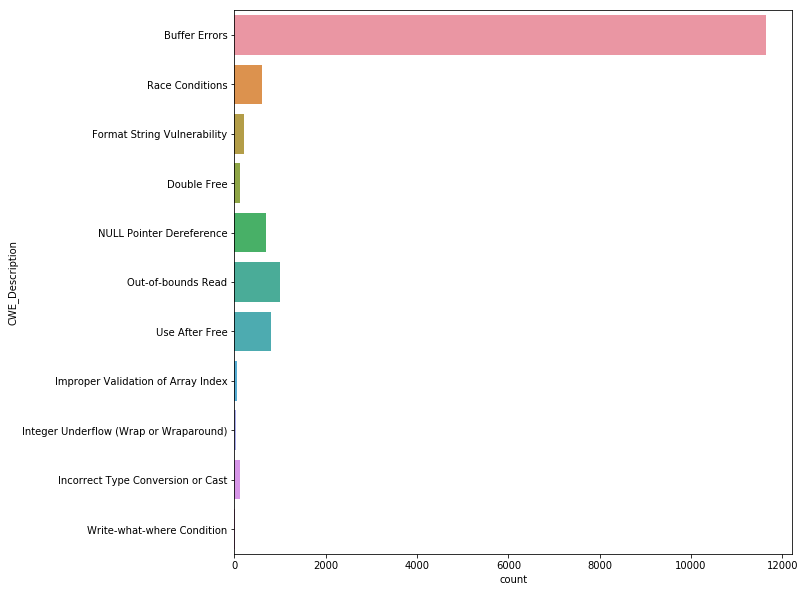

In [18]:
p = sns.countplot(y="CWE_Description", data=c_cpp_data)
p.figure.set_size_inches(10,10)

Now this is interesting, we have an alarmingly large number of error related to buffer overflow over all these years, followed by Out-of-bound Read and others. This is also interesting as out of all the C/C++ categories we had (about 89), we only see these couple vulnerabilities reported the most. We can see why Alex had the opinions he had formed as one can argue that bugs like buffer errors, out-of-bounds read, null pointer dereference and such are almost always taken care of in memory-safe languages. However, let's look at the trend of these categories of vulnerabilities as they are pretty interesting ones outside of the bugs related to Web.

For this we will be grouping the C/C++ data by year and then by their CWE category description. We need to count this aggregation.

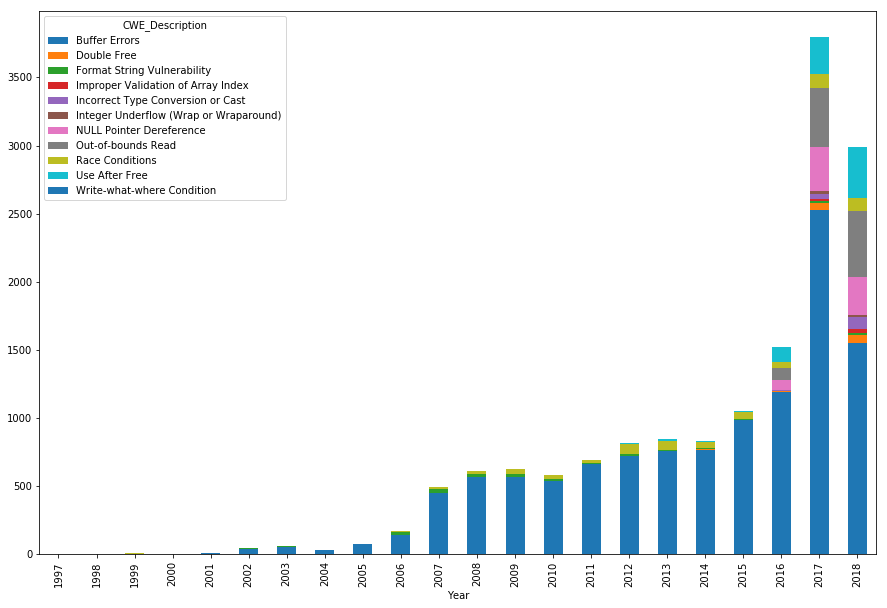

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
c_cpp_data.groupby(['Year','CWE_Description']).count()['CWE'].unstack().plot(kind='bar',stacked=True,ax=ax)

Buffer Errors as we expected are majority of the culprit on the rise as the years go by. However, we also see memory unsafety errors like use after free and out of bounds read to be rising as well. 2017 seems to have been a big year for vulnerabilities, possibly due to vulnerabilities like WannaCry. Buffer errors seem to be reported lower in 2018 even though vulnerabilites like Spectre were out this year. However, Use after free and Out of bounds Read error did increase in 2018 a bit. So we know that buffer overflow and memory errors have been on the rise and C/C++ are almost always the culprit language for these memory issues. However, just because the vulnerabilties are out doesn't mean they are always exploitable and impactful. Let's look if memory errors are as exploitable as they are cooked out to be

## Over the years has the average baseScore risen in general and among C/C++ vulnerabilities?

To see this trend, we will be using a linegraph of the average scores of base, impact as well as exploitability. Note we are looking at the entire dataset first

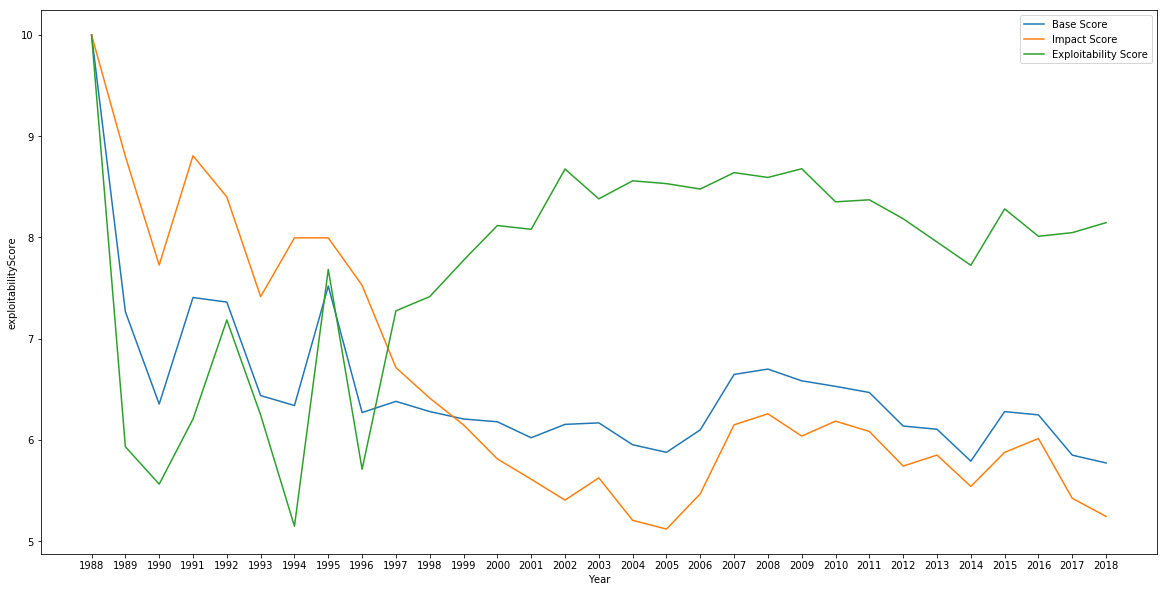

In [22]:
avg_cve_score = cve_data.groupby('Year').mean().reset_index()
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['baseScore'],label='Base Score')
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['impactScore'], label = 'Impact Score')
p = sns.lineplot(x=avg_cve_score['Year'],y=avg_cve_score['exploitabilityScore'], label = 'Exploitability Score')

p.figure.set_size_inches(20,10)

It makes sense for baseScore and impactScore to follow as baseScore combines impactScore and exploitabiityScore. However, it weighs impactScore heavily in V2 metric system of CVSS. It is quite interesting to see however, that over the years, exploitabilityScore has risen. ExploitabilityScore accounts for Access Vector, Access Complexity along with Authentication in V2 metric calculation system. Exploitability score hints us how easily attackable these vulnerabilities are. However, looking at the formula given by [CVSS](https://www.first.org/cvss/v2/guide), we can conclude that the impact score is driving the base score here. Impact score is driven impact categories: ConfidentialityImpact, AvailabilityImpact, IntegrityImpact. Since this is the entire dataset, the category of CWE-OTHERS could be showing the trend downwards. Let's look at specifically the categories of CVE that are related to C/C++ (Memory related)

[Text(0,0.5,'Scores')]

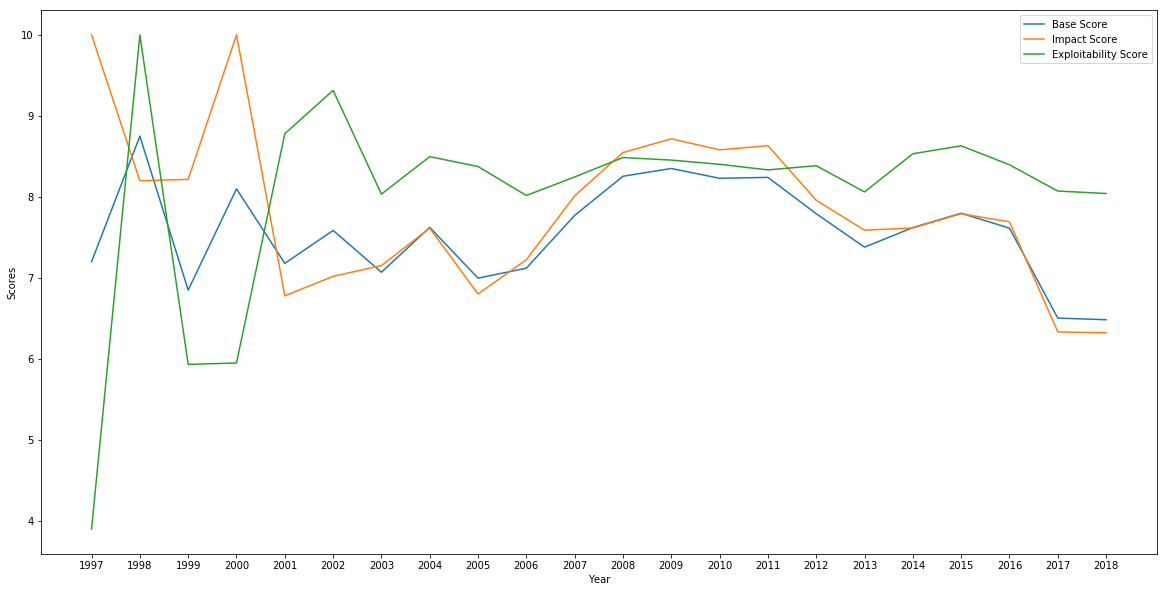

In [23]:
avg_cve_score_cpp= c_cpp_data.groupby('Year').mean().reset_index()
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['baseScore'],label='Base Score')
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['impactScore'], label = 'Impact Score')
p = sns.lineplot(x=avg_cve_score_cpp['Year'],y=avg_cve_score_cpp['exploitabilityScore'], label = 'Exploitability Score')

p.figure.set_size_inches(20,10)
p.set(ylabel='Scores')



Here we can see that all the scores follow a similar trend. Exploitability score has stabilized over the years for memory related errors. However, it is still considered high as it is above 7. Over the recent years, the memory related bugs have exploded, their impact is Medium while their Exploitability being High. These vulnerabilities include WannaCry[[BaseScore: High]](https://nvd.nist.gov/vuln/detail/CVE-2017-8620), HeartBleed[[BaseScore: Medium]](https://nvd.nist.gov/vuln/detail/CVE-2014-0160) and Spectre[[BaseScore: High]](https://nvd.nist.gov/vuln/detail/CVE-2017-5753)related vulnerabilities that we saw over few years recently.

## Scores over the Years By CWE Description for C/C++ Vulnerabilities

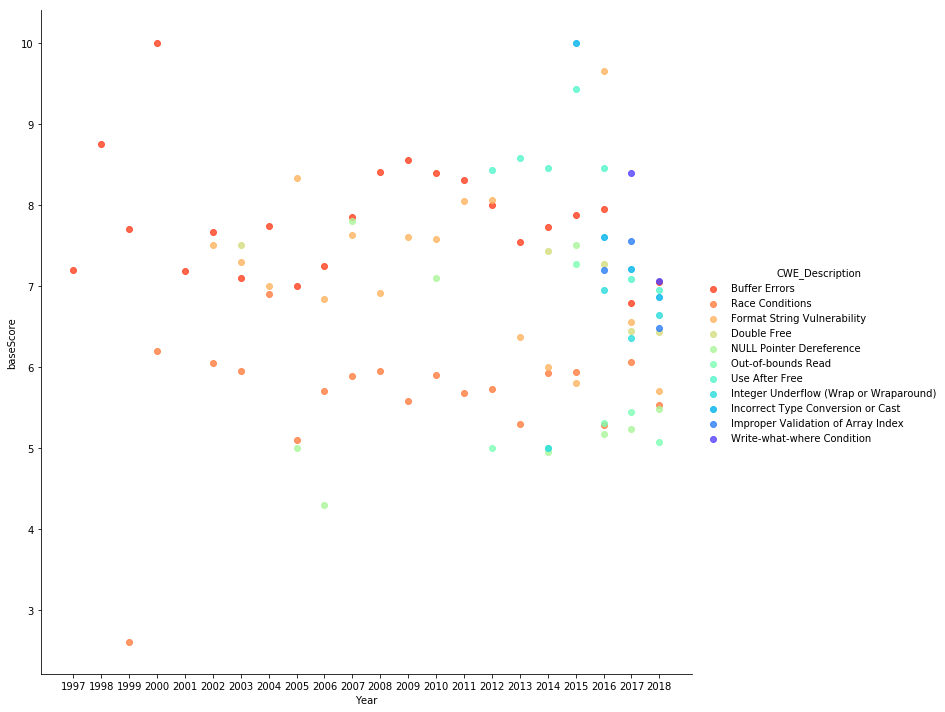

In [24]:
sns.lmplot('Year', 'baseScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette ='rainbow_r')


We can see that almost every year, buffer errors receive a high score on average while Race Conditions usually are classified as a medium. Since 2013 to 2017. Buffer errors have had a trend of average high base score. To understand this a bit more. Lets also plot these for impact and exploitability scores

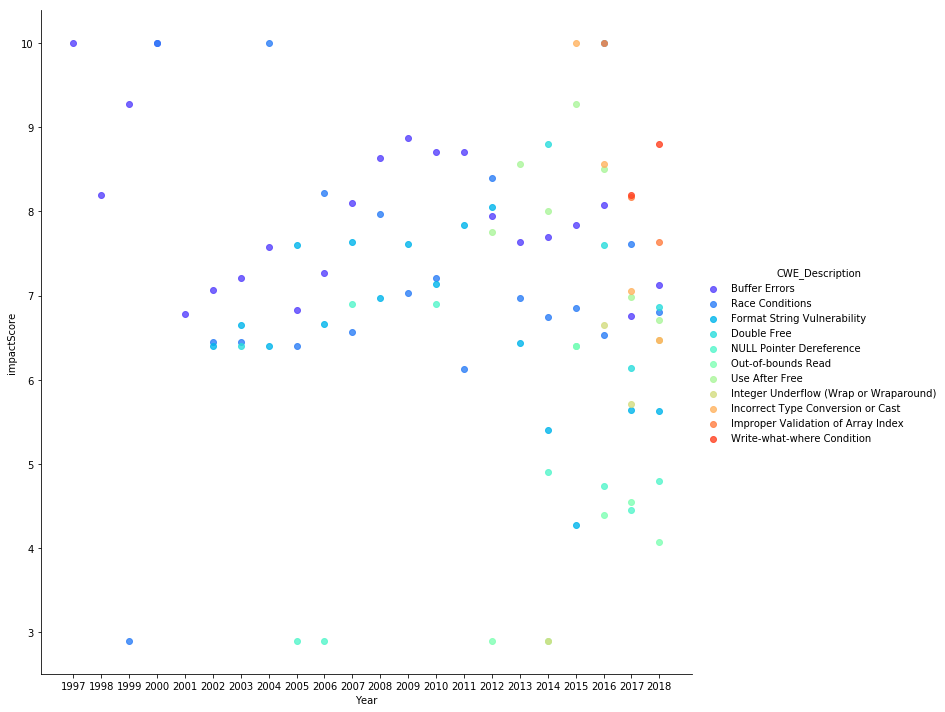

In [25]:
sns.lmplot('Year', 'impactScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette='rainbow')


The trend of average impactScore follows the same as base score for buffer errors. However, we can see that Write-what-where condition was reigned on a high impact score in 2018. We can also notice that out of bounds and use after free vulnerabilities impact has increased on average over the years

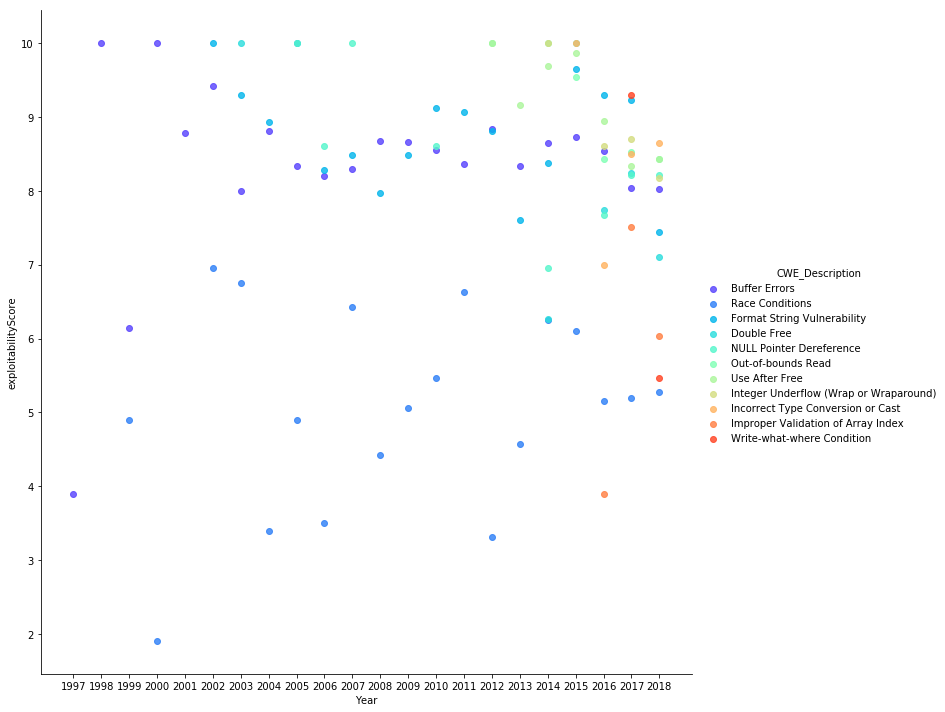

In [26]:
sns.lmplot('Year', 'exploitabilityScore', fit_reg = False, hue='CWE_Description', 
           data=c_cpp_data.groupby(['Year','CWE_Description']).mean().reset_index().sort_values(by='Year'), 
           height = 10, palette='rainbow')

Here we notice that buffer errors are still highly exploitable. This also means that the accessComplexity for them is low once gained access from the access Vector. We also notice that user after free vulnerabilites have increased in exploitablity over the years. What does this all say for memory errors? Memory errors are still being found and are on the rise for being highly exploitable. This is a good argument to move to a memory safe language. However, moving a code base is very expensive and furtheremore, alot of libraries that many software depend on have already been written and are out in the use widely. Making a move to memory safe language, converting each of these libraries like apache, linux is a long and expensive process. We can definitely lower the impact and exploitability using best practices but going forward, this makes a good argument to start considering migrating our critical libraries to a memory safe language 

We can also conjecture easily that vulnerabilities are on the rise with the advent of Internet but just how much of the vulnerabilties can we attribute to Internet than local use. For this, I will be looking at the categories of accessVector provided by CVSS's version 2 metric system. It is to note that I am using version 2 instead of version 3 as version 3, while robust, is fairly new metric that isn't quantified to plethora of older vulnerabilities prior to 2016. Access vectors are of three categories: Local, Network or Adjacent Network and they define how a vulnerability can be exploited.

# Open Web Application Security Project (OWASP)

Every few years, OWASP releases a list of the greatest vulnerabilites that were detected worldwide.  Since these vulnerabilites apply to web-facing services, they give us a completely different set of vulnerabilites than before.  

In [27]:
#Data downloaded from https://cwe.mitre.org/data/definitions/1026.html
owasp = pd.read_csv('cwe_owasp_2017.csv')
result = owasp['ID'].astype(str)
owasp_data = cve_data[cve_data['CWE'].str[4:].isin(result)]
recent_owasp_data = owasp_data.loc[owasp_data['Year'].isin(['2017','2018'])]

This csv file contains the CWE codes for OWASP's Top Ten 2017 weaknesses classifications.

By sorting the table used previously, we can select only the classifications from OWASP for 2017 and 2018.

In [28]:
new_column = recent_owasp_data['publishedDate'].str.split('-', n=2, expand=True)
recent_owasp_data['Month'] = recent_owasp_data['Year'] + '-' + new_column[1]
recent_owasp_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,CVE_ID,CWE,accessVector,accessComplexity,authentication,confidentialityImpact,integrityImpact,availabilityImpact,baseScore,severity,exploitabilityScore,impactScore,publishedDate,lastModifiedDate,CWE_Description,Year,Month
29043,CVE-2007-6759,CWE-287,NETWORK,LOW,NONE,PARTIAL,PARTIAL,PARTIAL,7.5,HIGH,10.0,6.4,2017-04-07T21:59Z,2017-04-13T19:37Z,Authentication Issues,2017,2017-04
29044,CVE-2007-6760,CWE-287,NETWORK,LOW,NONE,PARTIAL,PARTIAL,PARTIAL,7.5,HIGH,10.0,6.4,2017-04-07T21:59Z,2017-04-13T19:38Z,Authentication Issues,2017,2017-04
36249,CVE-2008-7313,CWE-77,NETWORK,LOW,NONE,PARTIAL,PARTIAL,PARTIAL,7.5,HIGH,10.0,6.4,2017-03-31T16:59Z,2017-04-04T17:19Z,Command Injection,2017,2017-03
36250,CVE-2008-7315,CWE-77,NETWORK,LOW,NONE,PARTIAL,PARTIAL,PARTIAL,7.5,HIGH,10.0,6.4,2017-10-10T16:29Z,2017-11-03T17:15Z,Command Injection,2017,2017-10
36252,CVE-2008-7319,CWE-77,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,2017-11-07T21:29Z,2017-11-29T15:49Z,Command Injection,2017,2017-11


Next, we will add an additional column for the month of these vulerabilities, so we can closely look at this smaller sub-section.

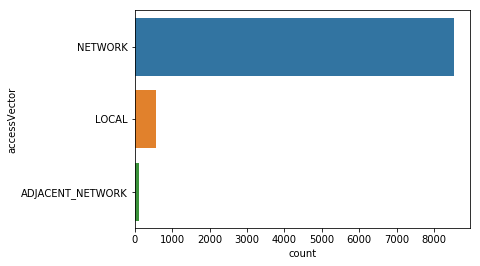

In [29]:
sns.countplot(y="accessVector", data=recent_owasp_data)

As you can see, almost all of the vulnerabilties occur over the network.  This is expected because these are vulnerabilities on web-facing machines.

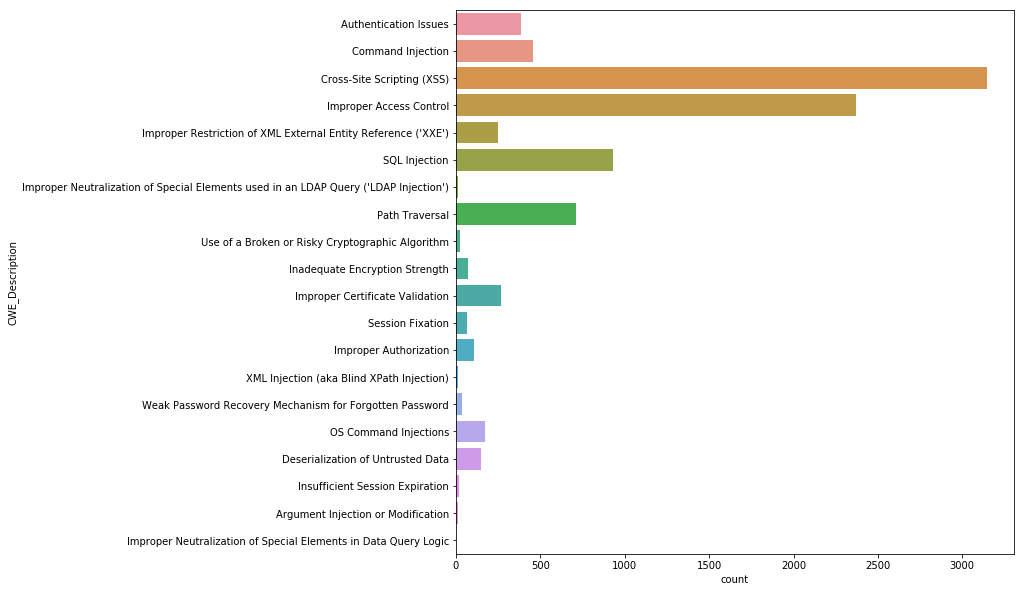

In [30]:
p = sns.countplot(y="CWE_Description", data=recent_owasp_data)
p.figure.set_size_inches(10,10)

Nearly all of the vulnerabilities fit into two categories, "Cross-Site Scripting (XSS)" and "Improper Access Control".  Based on the vulnerabilites with C and C++, you might expect that these vulnerabilites are evenly distributed accross 2017 and 2018 or that they are exponentially increasing as time progresses, but that is not the case, as we will see in the month break down.

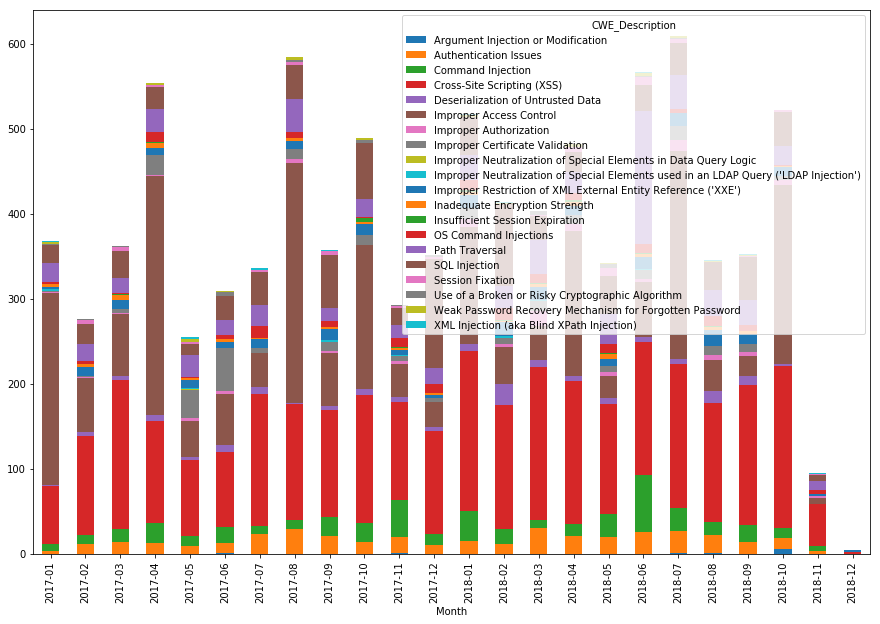

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
recent_owasp_data.groupby(['Month','CWE_Description']).count()['CWE'].unstack().plot(kind='bar',stacked=True,ax=ax)

Viewing the number of different vulnerabilities per month shows us some interesting data. 

1) Every three months (except for July 2017), the number of "Improper Access Control" vulnerabilities spike dramatically.

2) The number of "Path Traversal" vulnerabilities in June 2018 was almost as much as in the remaining months of 2017 and 2018 combined.  Even though the total number of "Cross-Site Scripting (XSS)" vulnerabilities over this two year span is many times greater than the number of "Path Traversal" vulnerabilities, there are more "Path Traversal" vulnerabilities than "Cross-Site Scripting (XSS)" vulnerabilities in June 2018.

3) The number of "SQL Injection" vulnerabilities in December 2017 and February 2018 were almost as much as in the remaining months of 2017 and 2018 combined.

4) The number of "Command Injection" vulnerabilities in November 2017 and June 2018 were almost as much as in the remaining months of 2017 and 2018 combined.

4) A vast majority of all "Use of a Broken or Risky Cryptographic Algorithm" vulnerabilities occured from April to June of 2017.

5) The number of "Cross-Site Scripting (XSS)" vulnerabilities remains fairly constant accross 2017 and 2018, but they are slowly increasing.

This sporadic surge and decline of certain vulnerabilites is expected.  Whether it is due to a company releasing a unsecure update or people finding an exploiting a previously unknown vulnerability, the number of these incidents will spike dramatically until they are able to patch the vulnerability.  

[Text(0,0.5,'Scores')]

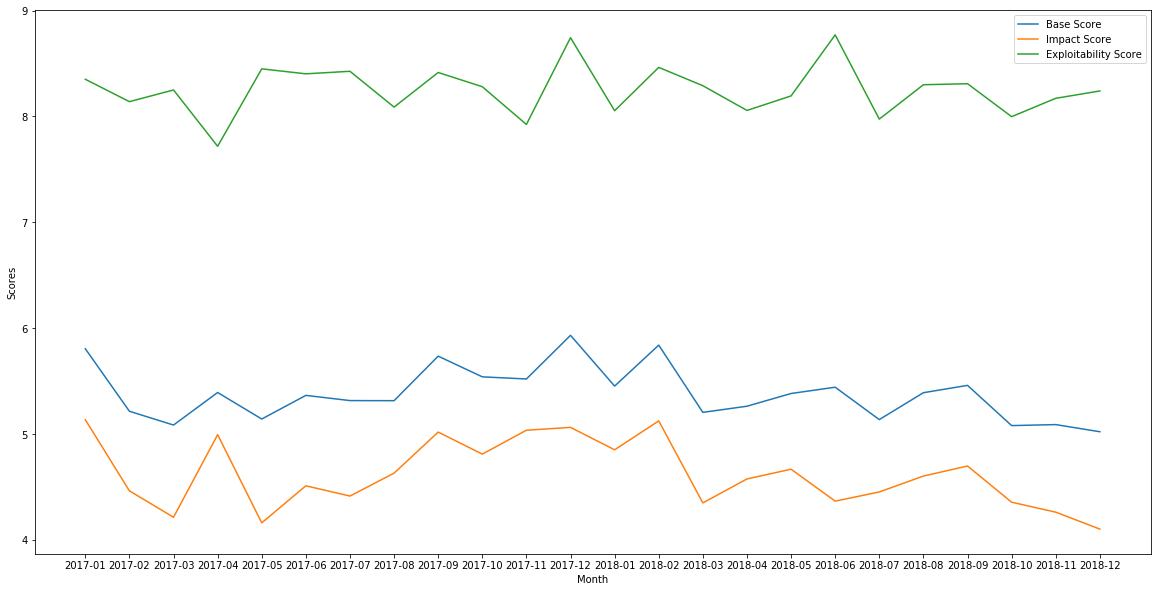

In [32]:
avg_recent_owasp_data= recent_owasp_data.groupby('Month').mean().reset_index()
p2 = sns.lineplot(x=avg_recent_owasp_data['Month'],y=avg_recent_owasp_data['baseScore'],label='Base Score')
p2 = sns.lineplot(x=avg_recent_owasp_data['Month'],y=avg_recent_owasp_data['impactScore'], label = 'Impact Score')
p2 = sns.lineplot(x=avg_recent_owasp_data['Month'],y=avg_recent_owasp_data['exploitabilityScore'], label = 'Exploitability Score')

p2.figure.set_size_inches(20,10)
p2.set(ylabel='Scores')


Looking at the average score per month for the OWASP vulnerabilities, we see that the scores are similar to those for C and C++ (from 2017 to 2018).  In both sets, the Impact Score is fairly low, along with the Base Score, while the Exploitability Score is fairly high.  The difference is that the OWASP scores have higher Exploitability Scores and lower Impact Scores, but this again is somewhat expected.  The OWASP vulnerabilites are on web-facing machines, so it is much easier to access these vulnerabilities and therefore easier to exploit.  However, web-facing machines also have limited access and permissions, so when someone exploits a vulnerability, the damage will be limited, therefore a low impact score.

# Further Reading

Common Weakness Evaluation (CVE) About Page - https://cwe.mitre.org/about/index.html

Open Web Application Security Project (OWASP) About Page - https://www.owasp.org/index.php/About_The_Open_Web_Application_Security_Project

National Institute of Standards and Technology (NIST) National Vulnerability Database (NVD) - https://nvd.nist.gov/

Common Vulnerability Scoring System (CVSS) FAQ - https://www.first.org/cvss/cvss-faq.pdf

Buffer Overflow - Wikipedia - https://en.wikipedia.org/wiki/Buffer_overflow

Buffer Overflow - OWASP - https://www.owasp.org/index.php/Buffer_Overflow

Cross-Site Scripting (XSS) - Wikipedia - https://en.wikipedia.org/wiki/Cross-site_scripting

Cross Site Scripting (XSS) - OWASP - https://www.owasp.org/index.php/Cross-site_Scripting_(XSS)